<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/bnp_paribas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 20th August, 2018
My folder: C:\Users\ashok\OneDrive\Documents\bnp_paribas_insurance
           /home/ashok/Documents/bnp_paribas_insurance/
Ref:
    Kaggle problem: https://www.kaggle.com/c/bnp-paribas-cardif-claims-management
    https://github.com/catboost/tutorials/blob/master/advanced_tutorials/kaggle_paribas.ipynb

Evaluation:
    logloss
    https://www.kaggle.com/c/bnp-paribas-cardif-claims-management#evaluation

Objectives:
    i)   Learn to work with catboost
    ii)  Plotting missingvalues graphs
            a. Matrix plots
            b. Heatmap/correlation plots
            c. dendogram plots
    ii)  Plotting ROC curve in python
    iii) Feature importance
    iv)  Grid search--parameter tuning

"""


In [ ]:
! pip install catboost

In [75]:
# 1.0 Call libraries
#%reset -f
import pandas as pd        # Data manipulation
import numpy as np         # Array manipulation

# 1.1 Modeling libraries
from sklearn.model_selection import train_test_split
# 1.1.1 For parameter-search over grid
from sklearn.model_selection import GridSearchCV
# conda install -c conda-forge catboost 
from catboost import CatBoostClassifier   # For classification
from catboost import Pool                 # Pool is catboost's internal data structure

# 1.2 Model performance
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# 1.3 For plotting
# conda install -c conda-forge scikit-plot
from sklearn.metrics import roc_curve
#import scikitplot as skplt      # For roc graphs
import matplotlib.pyplot as plt
import seaborn as sns

# 1.4 Plot missing values
#     Ref: https://github.com/ResidentMario/missingno
#     pip install missingno
import missingno as msno      # For missing plots


# 1.5 Misc
import os
import time
import gc

In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [8]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [42]:
filePath = "/gdrive/MyDrive/bnp_paribas"
# 2.0 Change working directory and read file
os.chdir(filePath)
#os.chdir("C:/Users/ashok/OneDrive/Documents/bnp_paribas_insurance")
# 2.1
train_df = pd.read_csv('train.csv.zip')

In [ ]:
# 2.2 Explore data
print(train_df.shape)          # 114321, 133
print()
print(train_df.columns)        # Column names
print()
print(train_df.dtypes)         # Column types
print()
# 2.3 Count of different dtypes
#     float64: 138, object: 19, int64: 6
train_df.dtypes.value_counts()
# Memory usage
print()
print(train_df.memory_usage().sum())  # 121637672 = 121mb

In [ ]:
train_df['target'].value_counts()

In [ ]:
df = train_df.select_dtypes(include = ['float64'])
print(df.max().max())
print(df.min().min())

In [ ]:
# StackOverFlow: https://stackoverflow.com/a/1658752
print(np.finfo('float64'))
print(np.finfo('float32'))

In [ ]:
df = train_df.select_dtypes(include = ['int64'])
print(df.max().max())
print(df.min().min())
int_cols = df.columns
int_cols

In [ ]:
print(np.iinfo('int64'))
print(np.iinfo('int32'))
print(np.iinfo('int16'))

In [ ]:
train_df[int_cols] = train_df[int_cols].astype('int16')
train_df.dtypes.value_counts()
print()
print(train_df.memory_usage().sum())  # 117522116 = 117mb

In [55]:
# 2.4.1 Just look at data upto IInd index
train_df.loc[:1 , train_df.dtypes == "object"].head(20)  # All have char data

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,C,XDX,C,C,A,C,G,DI,C,F,B,D,E,A,E,B,O,NaN,AU
1,C,GUV,C,C,A,E,G,DY,A,F,B,D,D,B,B,A,U,G,AF


In [61]:
# Calculate number of levels in each
df = train_df.loc[:1 , train_df.dtypes == "object"]
print()
df['v22'].value_counts()
print()
len(df['v22'].value_counts().index.values)


GUV    1
XDX    1
Name: v22, dtype: int64

2

In [62]:
for i in df.columns:
  print(i,len(df['v22'].value_counts().index.values))

v3 2
v22 2
v24 2
v30 2
v31 2
v47 2
v52 2
v56 2
v66 2
v71 2
v74 2
v75 2
v79 2
v91 2
v107 2
v110 2
v112 2
v113 2
v125 2


In [74]:
train_df.loc[:, train_df.dtypes == 'object'].isnull().sum().sort_values(ascending = False)
train_df.loc[:, train_df.dtypes == 'float64'].isnull().sum().sort_values(ascending = False)
train_df.loc[:, train_df.dtypes == 'int16'].isnull().sum().sort_values(ascending = False)


v30     60110
v113    55304
v56      6882
v3       3457
v31      3457
v22       500
v112      382
v125       77
v52         3
v91         3
v107        3
v74         0
v75         0
v66         0
v79         0
v47         0
v24         0
v110        0
v71         0
dtype: int64

v102    51316
v85     50682
v119    50680
v123    50678
v51     50678
        ...  
v12        86
v50        86
v10        84
v114       30
v14         4
Length: 108, dtype: int64

v129      0
v72       0
v62       0
v38       0
target    0
ID        0
dtype: int64

## Patterns in missing data

In [80]:
sample = train_df.sample(frac = 0.1)
sample.shape  # 11432, 133)

(11432, 133)

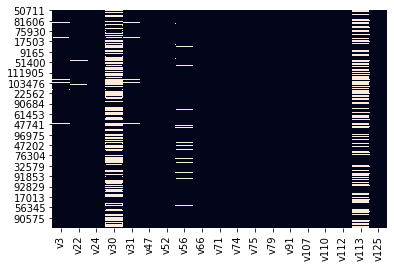

In [87]:
sns.heatmap(sample.loc[:, sample.dtypes=='object' ].isnull(), cbar=False);

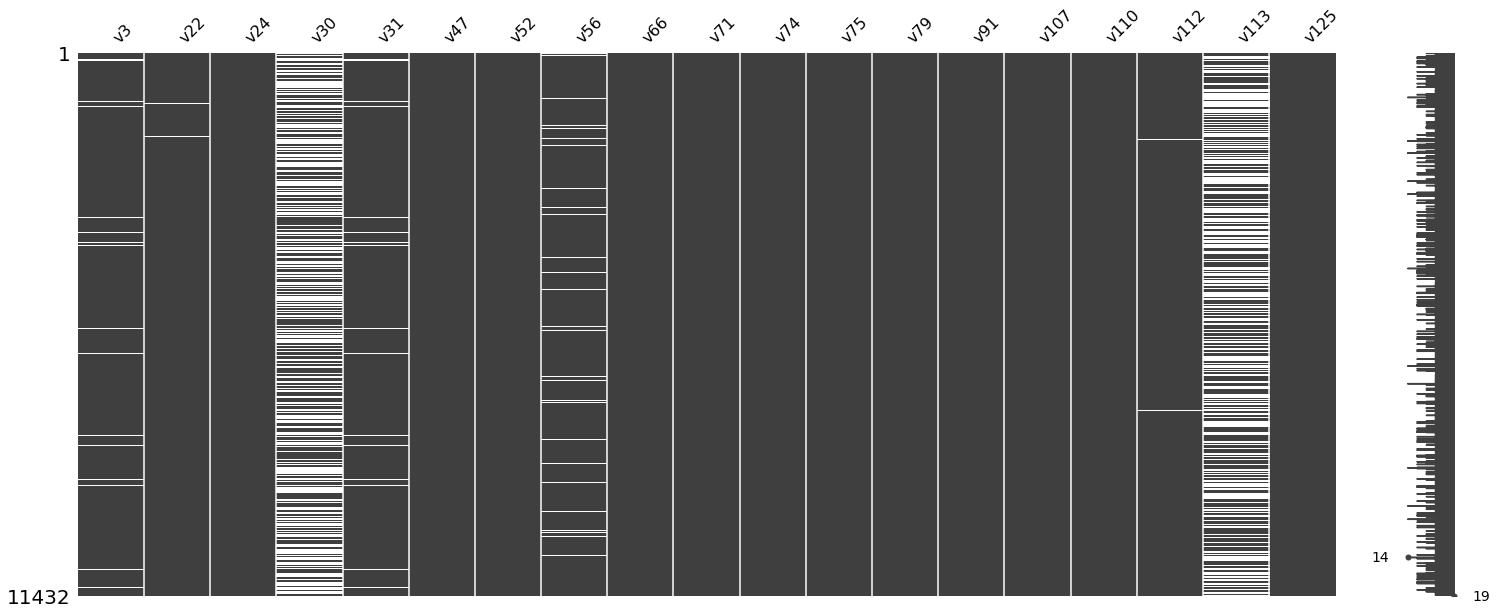

In [88]:
msno.matrix(sample.loc[:, sample.dtypes=='object' ]);

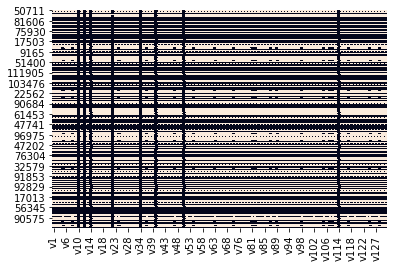

In [86]:
sns.heatmap(sample.loc[:, sample.dtypes=='float64' ].isnull(), cbar=False);

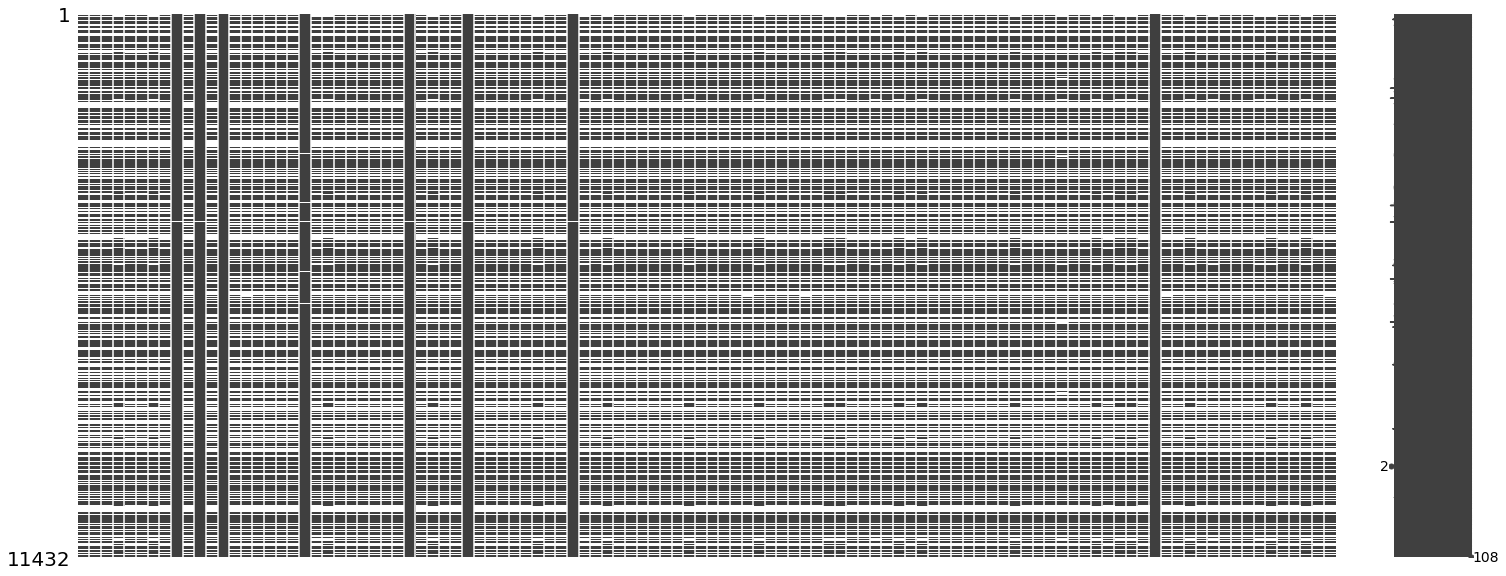

In [90]:
msno.matrix(sample.loc[:, sample.dtypes=='float64' ]);

In [ ]:
msno.dendrogram(sample.loc[:, sample.dtypes=='object' ])